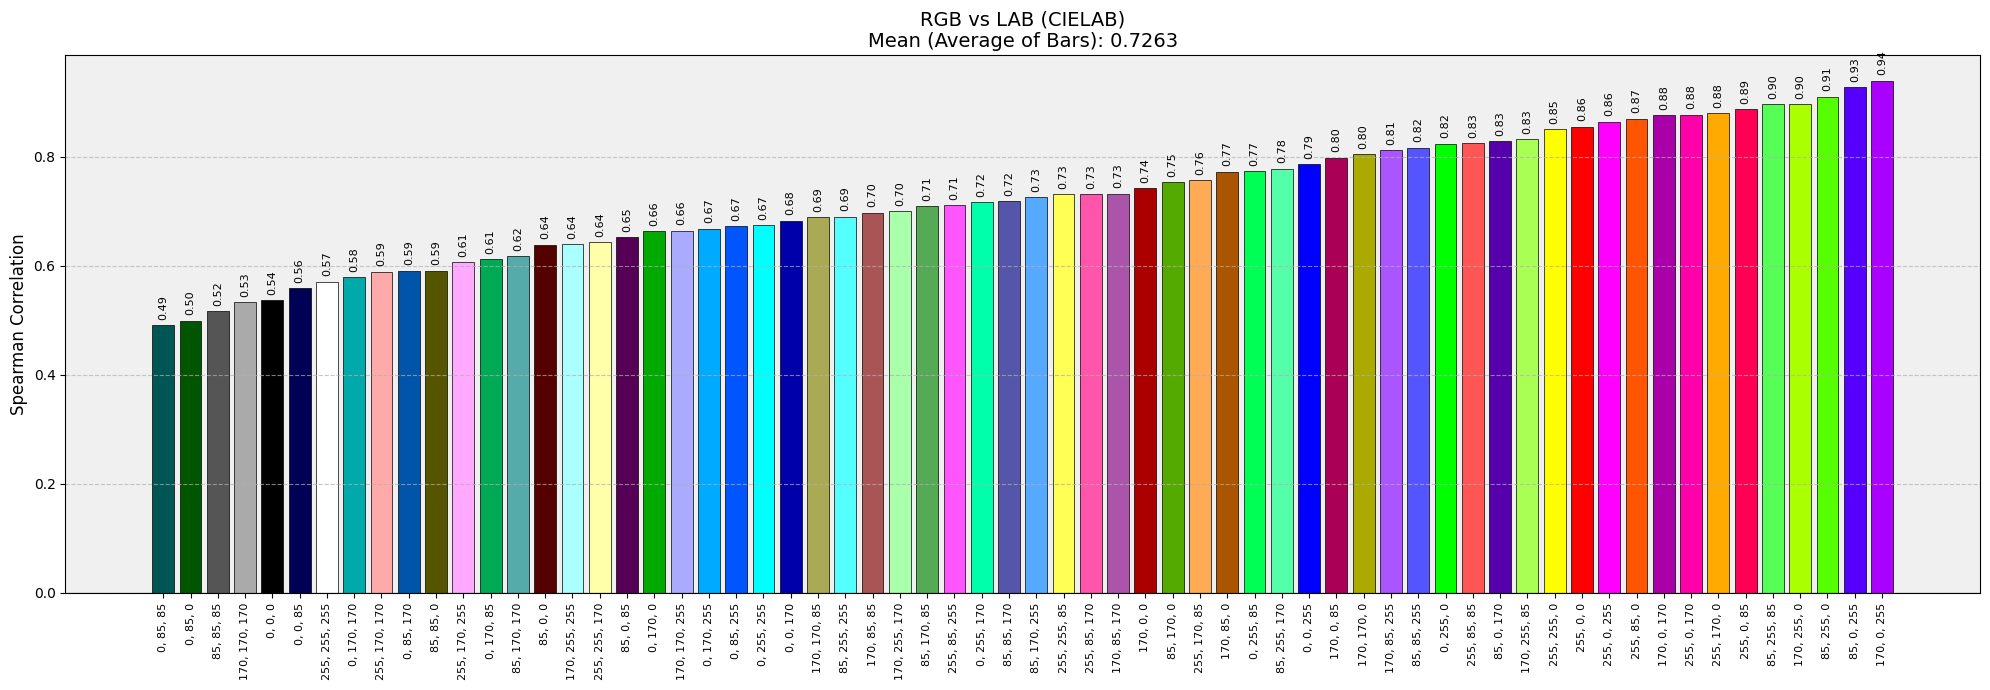

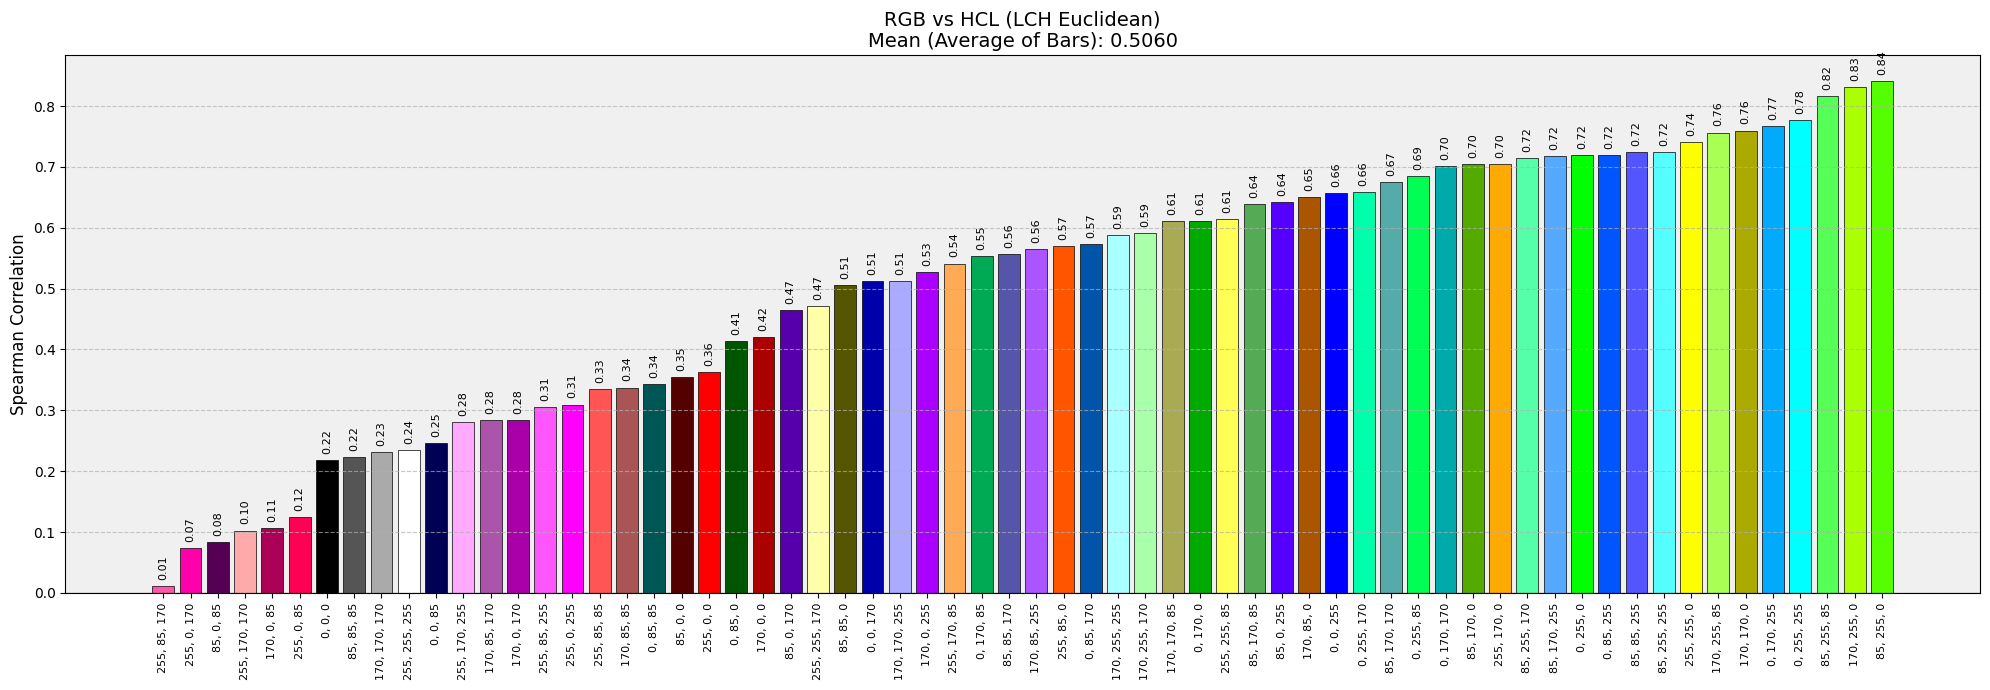

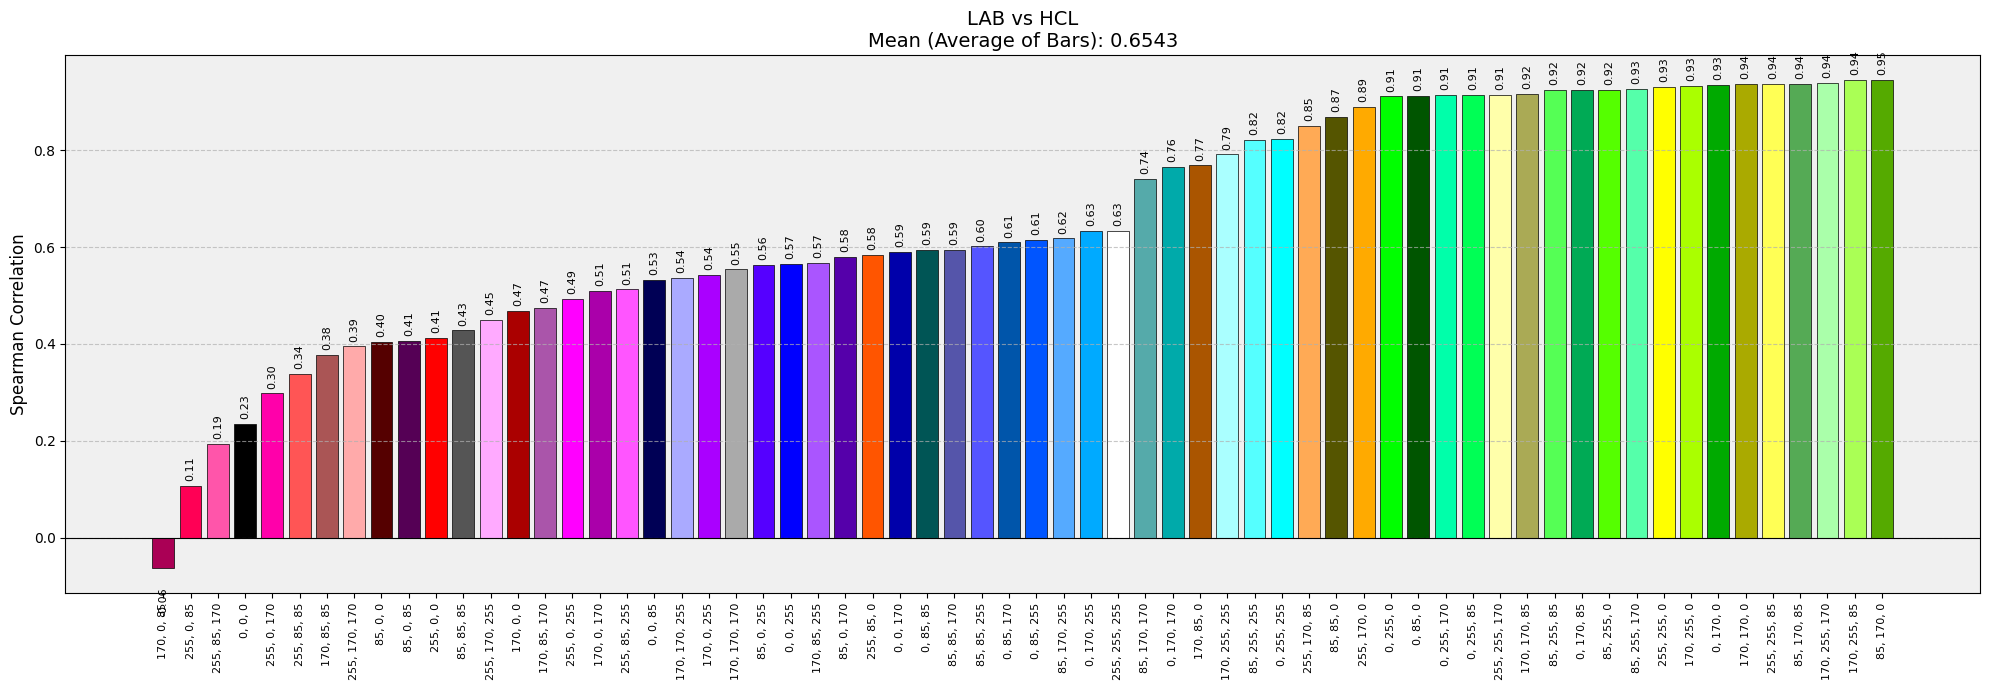

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
from scipy.stats import spearmanr
from scipy.spatial.distance import cdist

# --- 1. KONFIGURACJA I PRÓBKOWANIE ---
k = 4 
vals = np.linspace(0, 255, k).astype(int)
grid = np.array(np.meshgrid(vals, vals, vals)).T.reshape(-1, 3)
n_colors = len(grid)
rgb_norm = grid / 255.0

# --- 2. FUNKCJE KONWERSJI ---

def get_lab_coords(rgb):
    """RGB [0,1] -> CIELAB (L*, a*, b*)."""
    return color.rgb2lab(rgb)

def get_hcl_coords(rgb):
    """RGB [0,1] -> HCL (L, C, H) - współrzędne do odległości euklidesowej."""
    lab = color.rgb2lab(rgb)
    l = lab[:, 0]
    c = np.sqrt(lab[:, 1]**2 + lab[:, 2]**2)
    h = np.degrees(np.arctan2(lab[:, 2], lab[:, 1])) % 360
    return np.stack([l, c, h], axis=1)

# --- 3. MACIERZE ODLEGŁOŚCI ---

dist_rgb_mat = cdist(rgb_norm, rgb_norm, metric='euclidean')
dist_lab_mat = cdist(get_lab_coords(rgb_norm), get_lab_coords(rgb_norm), metric='euclidean')
dist_hcl_mat = cdist(get_hcl_coords(rgb_norm), get_hcl_coords(rgb_norm), metric='euclidean')

matrices = {
    'rgb': dist_rgb_mat,
    'lab': dist_lab_mat,
    'hcl': dist_hcl_mat
}

# --- 4. OBLICZANIE KORELACJI ---

def get_correlations(mat1, mat2):
    # Globalna (wszystkie unikalne pary)
    idx = np.triu_indices(n_colors, k=1)
    g_corr, _ = spearmanr(mat1[idx], mat2[idx])
    
    # Per Color (średnia z wysokości słupków)
    per_color_corrs = []
    for i in range(n_colors):
        v1 = np.delete(mat1[i], i)
        v2 = np.delete(mat2[i], i)
        corr, _ = spearmanr(v1, v2)
        per_color_corrs.append(corr)
    
    return g_corr, np.mean(per_color_corrs)

# --- 5. WYGENEROWANIE 9 REKORDÓW DO CSV ---

metrics = ['rgb', 'lab', 'hcl']
results = []

for m1 in metrics:
    for m2 in metrics:
        if m1 == m2:
            g_corr, m_corr = 1.0, 1.0
        else:
            g_corr, m_corr = get_correlations(matrices[m1], matrices[m2])
        
        results.append({
            "Category": m1.upper(),
            "Color_Metric": m2,
            "SAE_Type": "DirectMapping",
            "Global_Spearman": g_corr,
            "Mean_Per_Color_Spearman": m_corr
        })

df_summary = pd.DataFrame(results)
df_summary.to_csv("global_correlations_summary.csv", index=False)

# --- 6. PLOTOWANIE (3 KLUCZOWE WYKRESY) ---

def plot_per_color(mat1, mat2, title_prefix, filename):
    per_color_data = []
    for i in range(n_colors):
        v1 = np.delete(mat1[i], i)
        v2 = np.delete(mat2[i], i)
        corr, _ = spearmanr(v1, v2)
        per_color_data.append({
            'label': f"{grid[i][0]}, {grid[i][1]}, {grid[i][2]}",
            'corr': corr,
            'color': '#%02x%02x%02x' % tuple(grid[i])
        })
    
    df_bars = pd.DataFrame(per_color_data).sort_values('corr')
    mean_val = df_bars['corr'].mean()
    
    plt.figure(figsize=(20, 7))
    ax = plt.gca()
    ax.set_facecolor('#f0f0f0')
    bars = ax.bar(df_bars['label'], df_bars['corr'], color=df_bars['color'], edgecolor='black', linewidth=0.5)
    
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.01 if h >= 0 else h - 0.04,
                f'{h:.2f}', ha='center', va='bottom' if h >= 0 else 'top', fontsize=8, rotation=90)
    
    plt.title(f"{title_prefix}\nMean (Average of Bars): {mean_val:.4f}", fontsize=14)
    plt.ylabel("Spearman Correlation", fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Wykresy porównawcze
plot_per_color(dist_rgb_mat, dist_lab_mat, "RGB vs LAB (CIELAB)", "plot_rgb_lab.png")
plot_per_color(dist_rgb_mat, dist_hcl_mat, "RGB vs HCL (LCH Euclidean)", "plot_rgb_hcl.png")
plot_per_color(dist_lab_mat, dist_hcl_mat, "LAB vs HCL", "plot_lab_hcl.png")